# Doc2Vec


thoughts:

stop words vs no stop words

Try different instantiations of the Doc2Vec

Try training pre-trained wikipedia version

API doc [here](https://radimrehurek.com/gensim/models/doc2vec.html)

In [1]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import spacy
import gensim
import collections

# Loading Bugzilla Data

In [2]:
url = 'https://github.com/HSV-AI/bug-analysis/raw/master/data/df-xtext.parquet.gzip'
df = pd.read_parquet(url)

# Create a Tokenize Method
This method provides a simple list of words from the text. We will go ahead and run this against the bugs that we have loaded to find the total number of tokens.


In [3]:
nlp = spacy.load("en_core_web_sm")

exception_regex = re.compile(r".+Exception[^\n].*\s+at", re.MULTILINE | re.IGNORECASE)
greater_regex = re.compile(r"^> .*$", re.MULTILINE | re.IGNORECASE)
gerrit_created_regex = re.compile(r"New Gerrit change created: [^\ ]+", re.MULTILINE | re.IGNORECASE)
gerrit_merge_regex = re.compile(r"Gerrit change [^\s]+ was merged to [^\.]+\.", re.MULTILINE | re.IGNORECASE)
gerrit_commit_regex = re.compile(r"Commit: [^\ ]+", re.MULTILINE | re.IGNORECASE)

filter = ['VERB', 'NOUN', 'PROPN']

def tokenize_spacy(text):
    text = greater_regex.sub("", text)
    text = exception_regex.sub("", text)
    text = gerrit_created_regex.sub("", text)
    text = gerrit_merge_regex.sub("", text)
    text = gerrit_commit_regex.sub("", text)
    filtered_tokens = []
    
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
#             if re.fullmatch('[a-zA-Z]+', token.text) and not token.is_stop:
#            if token.pos_ in filter and re.fullmatch('[a-zA-Z]+', token.text):
            if re.fullmatch('[a-zA-Z]+', token.text):
                filtered_tokens.append(token.lemma_)
    return filtered_tokens


# Doc2Vec


In [4]:
def read_corpus():
  for i, row in df.iterrows():
    yield gensim.models.doc2vec.TaggedDocument(tokenize_spacy(row['text']), [row['id']])

train_corpus = list(read_corpus())

In [5]:
doc_id = random.randint(0, len(train_corpus) - 1)
doc = train_corpus[doc_id]
tag = doc.tags[0]
print(tag,doc.words)
text = df.iloc[doc_id]['text']
print('\n',text)

443574 ['Provide', 'exist', 'method', 'for', 'ifilesystemaccess', '-PRON-', 'would', 'be', 'helpful', 'if', 'a', 'file', 'system', 'access', 'could', 'be', 'query', 'if', 'a', 'file', 'exist', 'in', 'a', 'specified', 'output', 'configuration', '-PRON-', 'be', 'work', 'around', 'this', 'issue', 'currently', 'to', 'prove', 'a', 'the', 'manual', 'source', 'folder', 'for', 'the', 'case', 'that', 'a', 'file', 'that', 'should', 'be', 'generate', 'be', 'move', 'from', 'src', 'gen', 'for', 'manual', 'extension', '-PRON-', 'expect', 'this', 'need', 'another', 'ifilesystemaccessextension', 'to', 'be', 'add', 'this', 'method', 'could', 'have', 'the', 'signature', 'boolean', 'exist', 'String', 'fileName', 'String', 'outputcfgname', 'throw', 'RuntimeIOException', 'possible', 'workaround', 'see', 'if', 'string', 'throw', 'an', 'exception', 'call', 'string', 'and', 'pass', 'the', 'URI', 'to', 'Map', 'merge', 'into', 'master', 'thank', '-PRON-', 'Karsten', 'request', 'via', 'bug', 'request', 'via', 'b

In [6]:
# model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model = gensim.models.doc2vec.Doc2Vec(min_count=2, epochs=40)
%time model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
print(model.epochs)

CPU times: user 5.48 s, sys: 56 ms, total: 5.54 s
Wall time: 5.04 s
CPU times: user 1min 1s, sys: 764 ms, total: 1min 2s
Wall time: 24.4 s
40


In [7]:
model.docvecs.most_similar(231773)

[(348199, 0.6202988028526306),
 (402990, 0.582246720790863),
 (390326, 0.5723307132720947),
 (287071, 0.5684621930122375),
 (287550, 0.5651199817657471),
 (364955, 0.5634609460830688),
 (257940, 0.5621837973594666),
 (461470, 0.5605624318122864),
 (322203, 0.5603614449501038),
 (463101, 0.5562328100204468)]

In [8]:
from scipy import spatial

text1 = df.iloc[0,:]['text']
text2 = tokenize_spacy(text1)
vector = model.infer_vector(text2)
result = 1 - spatial.distance.cosine(model.docvecs[231773], vector)
print(result)

similar = model.docvecs.most_similar([vector])
print(similar)
print(df.iloc[0,2])

0.8196208477020264
[(231773, 0.8196208477020264), (463383, 0.7351096868515015), (473891, 0.7278515100479126), (287550, 0.7266017198562622), (463259, 0.7220456600189209), (476754, 0.7203495502471924), (476756, 0.7199193239212036), (480174, 0.717854917049408), (461165, 0.7177219390869141), (463256, 0.7162359356880188)]
231773


In [9]:
similarities = []
for doc_id in range(len(train_corpus)):
    learned_vector = model.docvecs[train_corpus[doc_id].tags[0]]
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    distance = 1 - spatial.distance.cosine(learned_vector, inferred_vector)
    similarities.append(distance)

/opt/tools/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.1442139595746994


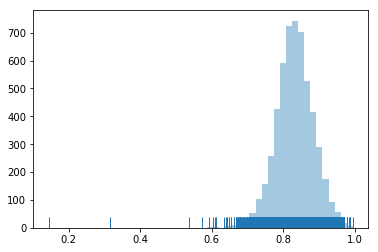

In [10]:
sns.distplot(similarities, kde=False, rug=True)
print(min(similarities))

Checking Self vs Other similarity.

## Note - this takes a long time

In [11]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [12]:
counter = collections.Counter(ranks)
print(counter)

Counter({260829: 2, 40642: 2, 513638: 2, 448395: 2, 405904: 2, 521274: 2, 497593: 2, 450194: 2, 497580: 2, 40323: 2, 506639: 2, 89761: 2, 505272: 2, 192309: 2, 417244: 2, 190609: 2, 381723: 2, 149543: 2, 62505: 1, 366245: 1, 277134: 1, 421746: 1, 91811: 1, 21856: 1, 489413: 1, 462784: 1, 374056: 1, 358973: 1, 141727: 1, 160403: 1, 526813: 1, 219599: 1, 432427: 1, 192285: 1, 233279: 1, 75913: 1, 148184: 1, 270692: 1, 201438: 1, 477538: 1, 51157: 1, 247847: 1, 238000: 1, 347851: 1, 344567: 1, 327580: 1, 222842: 1, 328537: 1, 144344: 1, 95383: 1, 177518: 1, 285044: 1, 538796: 1, 417702: 1, 562333: 1, 420163: 1, 403709: 1, 380697: 1, 190779: 1, 294974: 1, 160589: 1, 181620: 1, 275034: 1, 352332: 1, 545949: 1, 496261: 1, 396962: 1, 447986: 1, 237783: 1, 321138: 1, 504556: 1, 427140: 1, 45036: 1, 507246: 1, 535280: 1, 18645: 1, 132329: 1, 84177: 1, 167239: 1, 118910: 1, 96416: 1, 513027: 1, 1896: 1, 183037: 1, 337718: 1, 139034: 1, 68781: 1, 424334: 1, 79722: 1, 472253: 1, 170556: 1, 533068:

In [13]:
X = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    X.append(inferred_vector)

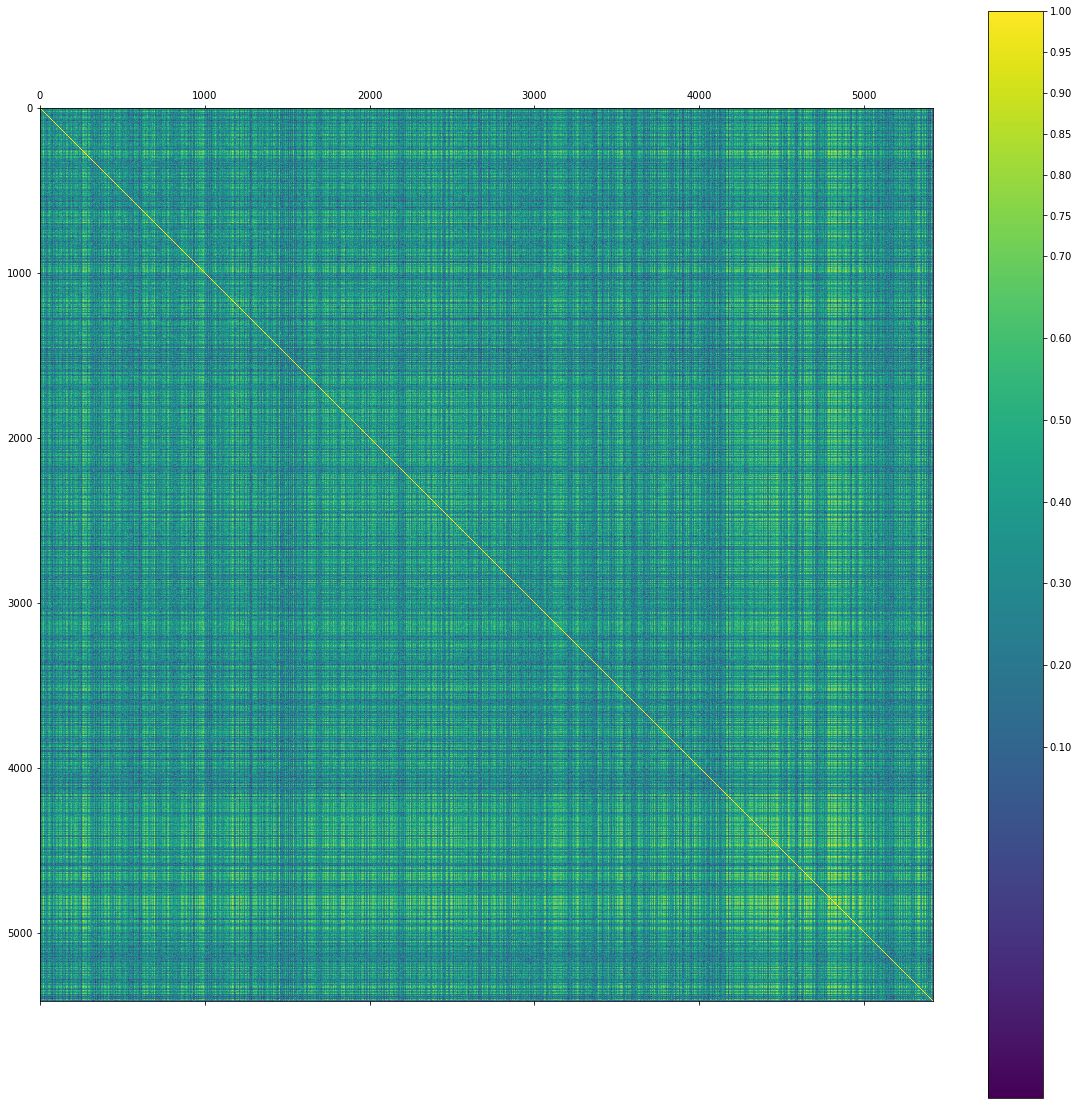

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
matrix = cosine_similarity(X)
 
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(matrix, interpolation='nearest')
# ax.grid(True)
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

In [15]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus) - 1)
doc = train_corpus[doc_id]
text = doc.words
print(doc.tags[0],text)

inferred_vector = model.infer_vector(doc.words)

sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

print()
text = df.loc[df['id'] == sims[1][0]].iloc[0]['text']
print(sims[1][0],text)


416306 ['tachment', 'Example', 'project', 'please', 'run', 'maven', 'install', '-PRON-', 'use', 'an', 'enumeration', 'that', 'override', 'tostre', 'as', 'an', 'annotation', 'value', 'the', 'annotation', 'value', 'have', 'a', 'default', 'value', 'when', 'use', 'xtend', 'batch', 'compiler', 'for', 'that', 'project', '-PRON-', 'get', 'the', 'exception', 'below', 'where', 'ist', 'the', 'tostring', 'result', 'for', 'the', 'enumeration', 'value', 'IMHO', '-PRON-', 'be', 'not', 'an', 'xtend', 'bug', '-PRON-', 'guess', 'should', 'use', 'name', 'instead', 'of', 'tostre', 'when', 'search', 'the', 'declare', 'field', 'for', 'the', 'enum', 'value', 'an', 'xtend', 'example', 'project', 'be', 'attach', '-PRON-', 'can', 'reproduce', 'the', 'bug', 'with', 'mvn', 'install', 'please', 'note', 'that', '-PRON-', 'be', 'not', 'unusal', 'to', 'override', 'tostring', 'of', 'enum', 'for', 'example', 'do', '-PRON-', 'ERROR', 'at', 'at', 'at', 'at', 'at', 'at', 'at', 'at', 'at', 'at', 'at', 'at', 'at', 'at', 'a

In [16]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=15)
kmeans.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
print(kmeans.cluster_centers_.shape)
print(kmeans.labels_.shape)
print(kmeans.labels_)

clusters = kmeans.labels_.tolist()
df['cluster'] = clusters
# print(train_corpus)
# l = kmeans.fit_predict(model.docvecs.vectors_docs)

(15, 100)
(5415,)
[14  9  3 ...  9  2 11]


[14  9  3 ...  9  2 11]


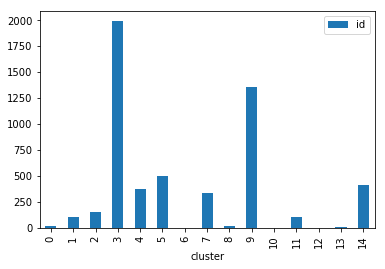

In [18]:
labels = kmeans.labels_
print(kmeans.labels_)

bugs = { 'id': df.loc[:,'id'], 'cluster': clusters }
frame = pd.DataFrame(bugs)
temp = frame.loc[:,['id','cluster']].groupby('cluster').count().plot.bar()
plt.show()

# Visualize the Results

This section uses several methods to visualize the results of the LDA.

Using PCA, create a 2D Visualizaton of the TF/IDF Matrix.

In [19]:
# Creating and fitting the tsne model to the document embeddings
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne_model = TSNE(n_jobs=4,
                  early_exaggeration=4,
                  n_components=2,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
tsne_d2v = tsne_model.fit_transform(np.array(X))


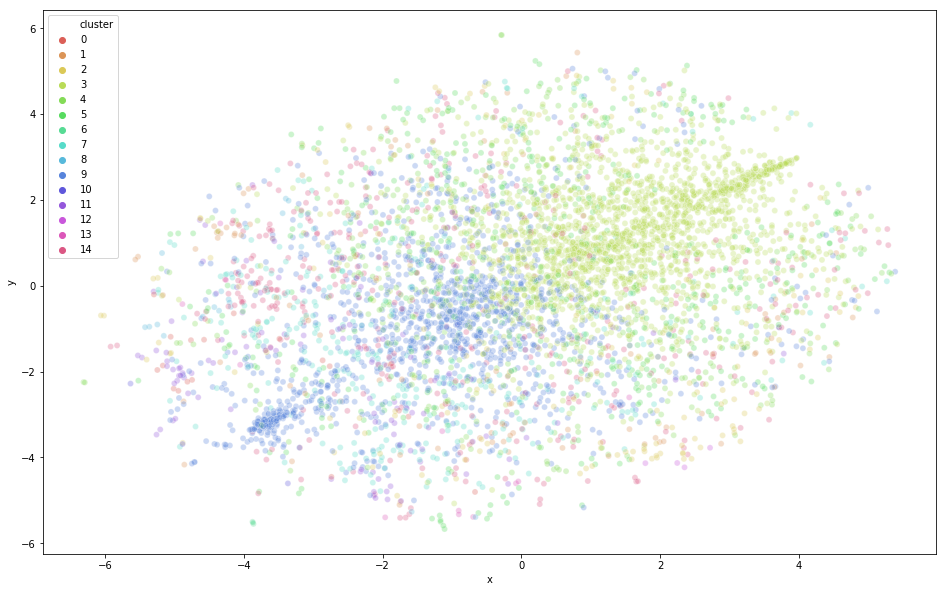

In [20]:
df['x'] = tsne_d2v[:,0]
df['y'] = tsne_d2v[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='x',
    y='y',
    hue="cluster",
    palette=sns.color_palette("hls", 15),
    legend="full",
    alpha=0.3,
    data=df
)

In [21]:
tsne_model = TSNE(n_jobs=4,
                  early_exaggeration=4,
                  n_components=3,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
tsne_d2v = tsne_model.fit_transform(np.array(X))


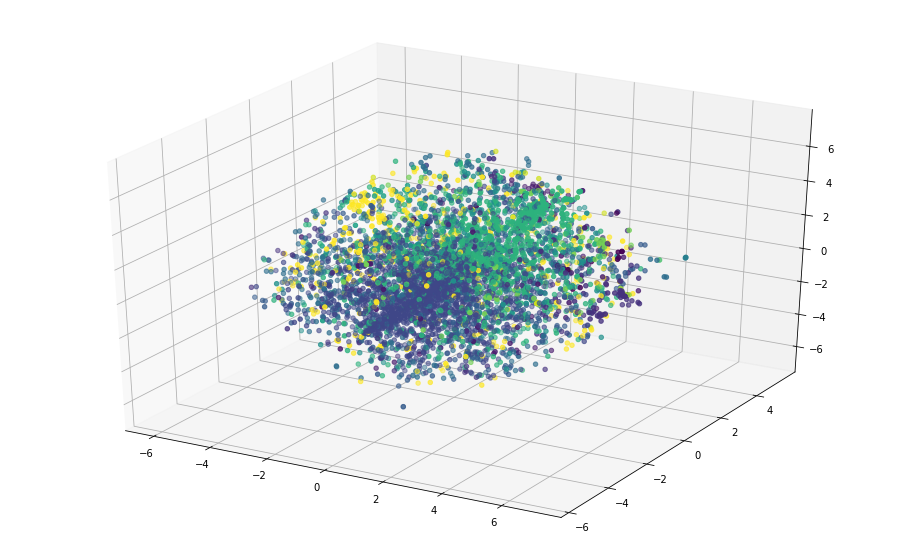

In [22]:
from mpl_toolkits.mplot3d import Axes3D

df['x'] = tsne_d2v[:,0]
df['y'] = tsne_d2v[:,1]
df['z'] = tsne_d2v[:,2]

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[:,"x"], 
    ys=df.loc[:,"y"], 
    zs=df.loc[:,"z"], 
    c=df.loc[:,"cluster"], 
)
plt.show()

In [23]:
from sklearn.decomposition import PCA

pca_20 = PCA(n_components=20)
pca_result_20 = pca_20.fit_transform(X)

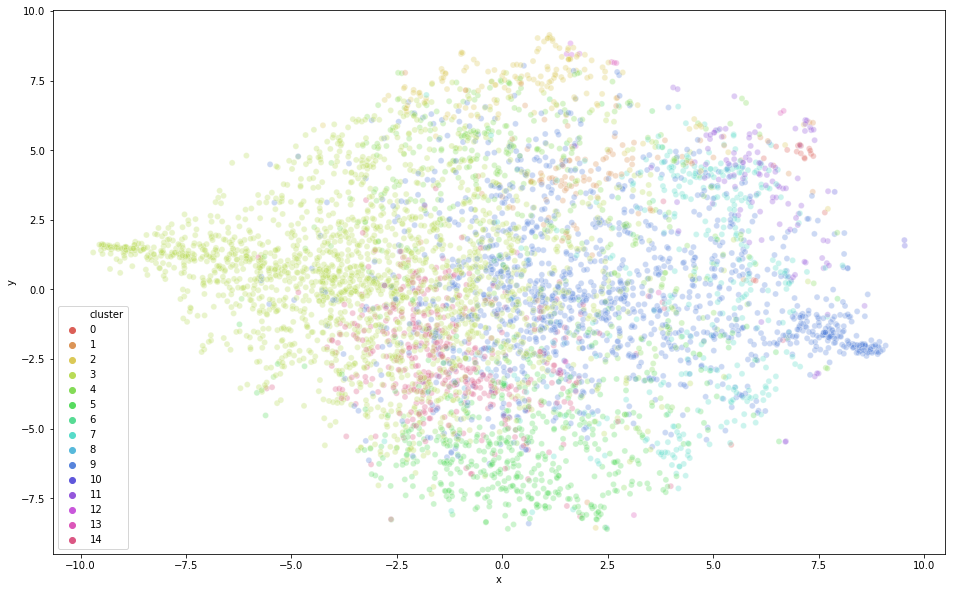

In [24]:
tsne_d2v = tsne_model.fit_transform(np.array(pca_result_20))
df['x'] = tsne_d2v[:,0]
df['y'] = tsne_d2v[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='x',
    y='y',
    hue="cluster",
    palette=sns.color_palette("hls", 15),
    legend="full",
    alpha=0.3,
    data=df
)

In [25]:
# from gensim.models.doc2vec import Doc2Vec
# loadedModel = Doc2Vec.load('PV-DBOW.doc2vec')